In [3]:
!git clone https://github.com/vuminhphuong11/NLP.git

fatal: destination path 'NLP' already exists and is not an empty directory.


In [4]:
pip install pyvi

In [5]:
import re# thư viện để python làm việc với biểu thức chính quy
import csv# thư viện để xử lí file .csv
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer# thư viện để tokenize
from pyvi import ViUtils


In [18]:

# đọc dữ liệu từ file gốc và sau đó loại bỏ stopwords và lưu lại vào file ra
input_file_path = 'train_data.csv'  # File CSV cần xử lý
output_file_path = 'data.csv'       # File CSV đầu ra
# Hàm đọc danh sách stopwords từ file
'''
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())  # Đọc từng dòng và lưu vào set
    return stopwords
# Lấy danh sách stopwords từ file

stopwords = load_stopwords('/content/NLP/vietnamese-stopwords.txt')
'''
# Hàm làm sạch văn bản
def clean_text(text):
    # Chuyển tất cả chữ về dạng viết thường
    text = text.lower()
    # Loại bỏ emoji, ký tự đặc biệt, chỉ giữ lại chữ cái và khoảng trắng
    text = re.sub(r'[^\w\sáàạảãạăắằặẳẵâấầậẩẫéèẹẻẽêếềệểễíìịỉĩóòọỏõôốồộổỗơớờợởỡúùụủũưứừựửữýỳýỵỷỹđ]', '', text)
    # Loại bỏ stopwords
    # text = ' '.join([word for word in text.split() if word not in stopwords])
    return text
# Đọc dữ liệu từ file CSV
try:
    with open(input_file_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        data1 = list(reader)  # Đọc toàn bộ dữ liệu từ file CSV
except FileNotFoundError:
    print(f"Không tìm thấy file: {input_file_path}")
    exit()
except csv.Error:
    print(f"Lỗi khi đọc file CSV: {input_file_path}")
    exit()
# Lọc và xử lý các mục comment, kiểm tra label và chỉ ghi lại những phần hợp lệ
processed_data1 = []
empty_rows = []  # Danh sách lưu dòng có dữ liệu trống
for index, item in enumerate(data1):
    comment = item.get('Comment', '').strip()
    label = item.get('Label', '').strip()
    # Kiểm tra dòng nào có dữ liệu bị trống
    if not comment or not label:
        empty_rows.append(index + 1)  # Lưu chỉ mục dòng (bắt đầu từ 1)
        continue
    # Xử lý comment
    cleaned_comment = clean_text(comment)
    processed_data1.append({'Comment': cleaned_comment, 'Label': label})
# Báo các dòng có dữ liệu bị trống
if empty_rows:
    print(f"Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': {empty_rows}")
# Ghi lại dữ liệu đã xử lý vào file CSV mới
try:
    with open(output_file_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['Comment', 'Label'])
        writer.writeheader()  # Ghi tiêu đề cột
        writer.writerows(processed_data1)  # Ghi dữ liệu
    print(f"Dữ liệu đã được ghi vào {output_file_path}")
except IOError:
    print(f"Không thể ghi dữ liệu vào file {output_file_path}")

Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': [2401, 2868]
Dữ liệu đã được ghi vào data.csv


In [19]:
data = pd.read_csv('data.csv')
data.head()

,Comment,Label
0,p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...,neutral
1,phần 2 gần như là 1 phần bôi nhọ phần 1 ai lạ...,negative
2,năm nay kiểu gì toàn bom tấn thành bom xịt ph...,negative
3,đúng là cảm xúc ở các đoạn cao trào vẫn làm ch...,neutral
4,phim khúc cuối nó dở 1 cái như phim việt nam,negative


In [20]:
st_data =pd.DataFrame({'Comment': data['Comment'],'Label': data['Label']})
st_data = st_data.dropna()
st_data = st_data.reset_index(drop=True)
st_data.head()

,Comment,Label
0,p1 kiệt tác mọi thời đại rồi nên cũng đừng kì ...,neutral
1,phần 2 gần như là 1 phần bôi nhọ phần 1 ai lạ...,negative
2,năm nay kiểu gì toàn bom tấn thành bom xịt ph...,negative
3,đúng là cảm xúc ở các đoạn cao trào vẫn làm ch...,neutral
4,phim khúc cuối nó dở 1 cái như phim việt nam,negative


### # Tạo một bản sao không có dấu, tokenization & lưu tạm

In [21]:
input_comment = st_data['Comment'].values
input_label = st_data['Label'].values
label_dictionary ={'positive':2,'neutral':1,'negative':0}
input_pre =[]
label_accent =[]
for idx, dt in enumerate(input_comment):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))# phần này là phần đã loại bỏ dấu
    input_text_pre_accent =ViTokenizer.tokenize(input_text_pre)# tokenization cho văn bản có dấu
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)# tokenization cho văn bản đã loại bỏ dấu
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_accent.append(input_label[idx])
    label_accent.append(input_label[idx])

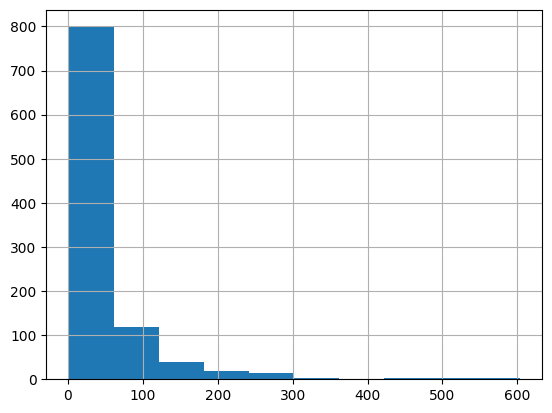

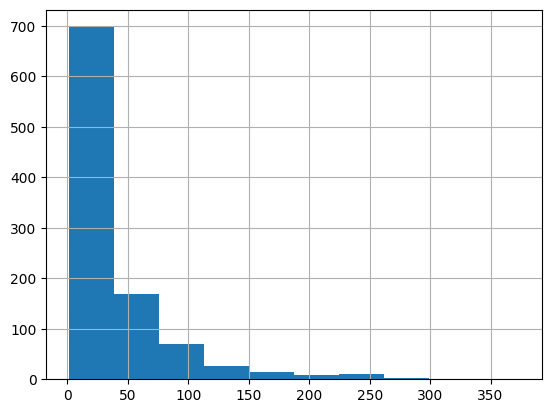

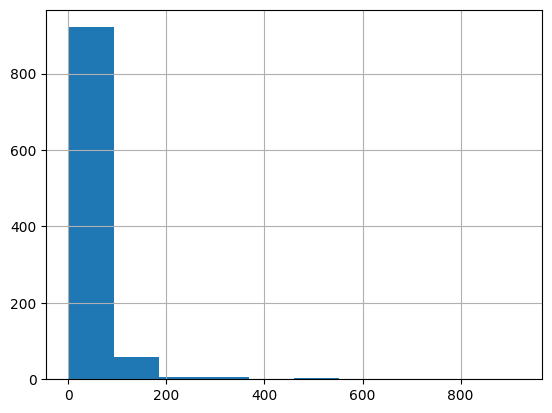

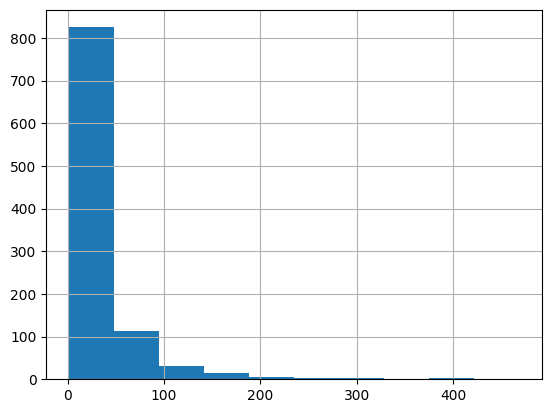

In [22]:
# lấy thông số và kiểm tra tần xuất
seq_len =[len(i.split())for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins =10)
plt.show()

In [23]:
file_path = 'data.csv'
df = pd.read_csv(file_path)
# Kiểm tra xem cột 'Comment' có tồn tại trong file không
if 'Comment' in df.columns:
    # Đếm số từ trong mỗi bình luận
    df['word_count'] = df['Comment'].apply(lambda x: len(str(x).split()))
    # Tìm bình luận có số từ nhiều nhất
    max_word_count_row = df.loc[df['word_count'].idxmax()]
    print(f"Bình luận có số từ nhiều nhất là ở dòng {max_word_count_row.name} với {max_word_count_row['word_count']} từ.")
    print(f"Đoạn bình luận: {max_word_count_row['Comment']}")
else:
    print("Không tìm thấy cột 'Comment' trong file CSV.")

Bình luận có số từ nhiều nhất là ở dòng 1386 với 939 từ.
Đoạn bình luận: có lẽ là câu chuyện quan điểm cá nhân nhưng mình không đồng tình lắm với cách phân tích của bạn việt dương
có kha khá khán giả thấy bộ phim hay về câu chuyện trong đó có mìnhmình thấy phim có 1 câu chuyện rõ ràng có những cứ twist khiến khán giả thấy thú vị và cách kể đủ sự lôi cuốn
nhân vật linh dù giới thiệu qua ở đầu phim nhưng ta vẫn đủ hiểu linh là 1 mẫu thục nữ điển hình trong thời phong kiến xưa nhà nghèo và có 1 cuộc tình đẹp từ bé mình không nghĩ đó là sơ sài nó vừa đủ cho người xem hiểu bắt đầu cùng mạch truyện tìm hiểu khám phá nhân vật này và thực sự càng xem mình càng thấy victor vũ khắc hoạ khai thác rất hay làm người xem không bị shock thông tin lúc đầu mà từ từ tìm hiểu linh 1 cô gái hiền lành cam chịu khéo tay thương con và có 1 tình yêu mãnh liệt 
nhân vật nhân cái này mình phải công nhận là hơi ít sự giới thiệu cũng như câu chuyện 7 năm của nhân hơi qua loa nhưng với thời lượng của phim việc cân

In [24]:
# chuyển đổi nhãn thành số và dạng one hot encoding
label_idx =[label_dictionary[i]for i in label_accent]
label_tf =tf.keras.utils.to_categorical(label_idx,num_classes=3)
# Tạo một tokenizer cho việc tách từ trong văn bản
tokenizer_data=Tokenizer(oov_token='<OOV>', split=' ')
# huấn luyện
tokenizer_data.fit_on_texts(input_pre)
# chuyển văn bản thành các chuỗi số
tokenizer_data_text=tokenizer_data.texts_to_sequences(input_pre)
# Padding các chuỗi số, đảm bảo mỗi chuỗi có độ dài cố định (512 từ)
vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen=512)
# Lưu tokenizer đã huấn luyện vào file pickle để sử dụng sau này
pickle.dump(tokenizer_data,open("tokenizer_data.pkl", "wb"))
print("comment data.shape ",vec_data.shape)
data_voca_size =len(tokenizer_data.word_index)+1
print("data_voca_size: ",data_voca_size)
#chia tệp dữ liệu thành bộ train và bộ validation 8-2
x_train, x_val,y_train,y_val= train_test_split(vec_data, label_tf,test_size=0.2,random_state=42)
#chia tệp dữ liệu thành bộ train và bộ test 9-1
x_train, x_test,y_train,y_test= train_test_split(vec_data, label_tf,test_size=0.1,random_state=42)
print("training sample: ",len(x_train))
print("validation sample: ",len(x_val))
print("test sample: ",len(x_test))

comment data.shape  (6462, 512)
data_voca_size:  6769
training sample:  5815
validation sample:  1293
test sample:  647


In [66]:
'''
def generate_model():  # Hàm chạy chính cho model KSTM và CNN
    dropout_threshold = 0.4
    input_dim = data_voca_size
    output_dim = 32
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    # CNN
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # LSTM
    lstm_feature = LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer)(feature)
    lstm_feature = MaxPooling1D()(lstm_feature)

    # Self-Attention
    query = Dense(32)(lstm_feature)
    key = Dense(32)(lstm_feature)
    value = Dense(32)(lstm_feature)

    attention_scores = tf.keras.layers.Dot(axes=[2, 2])([query, key])  # Q x K^T
    attention_scores = tf.keras.layers.Softmax()(attention_scores)      # Softmax(Q x K^T)
    attention_output = tf.keras.layers.Dot(axes=[2, 1])([attention_scores, value])  # Attention x V

    attention_output = tf.keras.layers.Cropping1D(cropping=(0, attention_output.shape[1] - 128))(attention_output)

    # Kết hợp các đặc trưng
    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, attention_output])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Classifier
    Classifier = Dense(90, activation='relu')(combine_feature)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(70, activation='relu')(Classifier)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(50, activation='relu')(Classifier)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(30, activation='relu')(Classifier)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(3, activation='softmax')(Classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=Classifier)
    return model

# Tạo và biên dịch model
model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_29 (Embedding)  │ (None, 512, 32)        │        216,608 │ input_layer_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_58 (Conv1D)        │ (None, 512, 32)        │          3,104 │ embedding_29[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_29 (LSTM)            │ (None, 512, 32)        │          8,320 │ embedding_29[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_109         │ (None, 256, 32)        │              0 │ conv1d_58[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_111         │ (None, 256, 32)        │              0 │ lstm_29[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_162 (Dropout)     │ (None, 256, 32)        │              0 │ max_pooling1d_109[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_151 (Dense)         │ (None, 256, 32)        │          1,056 │ max_pooling1d_111[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_152 (Dense)         │ (None, 256, 32)        │          1,056 │ max_pooling1d_111[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_59 (Conv1D)        │ (None, 256, 32)        │          3,104 │ dropout_162[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_14 (Dot)              │ (None, 256, 256)       │              0 │ dense_151[0][0],       │
│                           │                        │                │ dense_152[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_110         │ (None, 128, 32)        │              0 │ conv1d_59[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax_7 (Softmax)       │ (None, 256, 256)       │              0 │ dot_14[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_153 (Dense)         │ (None, 256, 32)        │          1,056 │ max_pooling1d_111[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_80    │ (None, 128, 32)        │             64 │ max_pooling1d_110[0][… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_15 (Dot)              │ (None, 256, 32)        │              0 │ softmax_7[0][0],       │
│                           │                        │                │ dense_153[0][0]        │
├──────────────────────

 Total params: 251,889 (983.94 KB)

 Trainable params: 251,889 (983.94 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
def generate_model():  # Hàm chạy chính cho model KSTM và CNN
    dropout_threshold = 0.4
    input_dim = data_voca_size
    output_dim = 32
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer="GlorotNormal")(input_layer)

    # CNN
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # LSTM (thay BiLSTM bằng LSTM)
    lstm_feature = LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer)(feature)
    lstm_feature = MaxPooling1D()(lstm_feature)
    lstm_feature = GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer)(lstm_feature)
    lstm_feature = MaxPooling1D()(lstm_feature)
    lstm_feature = LayerNormalization()(lstm_feature)

    # Kết hợp các đặc trưng
    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Classifier
    Classifier = Dense(90, activation='relu')(combine_feature)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(70, activation='relu')(Classifier)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(50, activation='relu')(Classifier)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(30, activation='relu')(Classifier)
    Classifier = Dropout(0.2)(Classifier)
    Classifier = Dense(3, activation='softmax')(Classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=Classifier)
    return model

# Tạo và biên dịch model
model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_39 (Embedding)  │ (None, 512, 32)        │        216,608 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_78 (Conv1D)        │ (None, 512, 32)        │          3,104 │ embedding_39[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_144         │ (None, 256, 32)        │              0 │ conv1d_78[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_222 (Dropout)     │ (None, 256, 32)        │              0 │ max_pooling1d_144[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_39 (LSTM)            │ (None, 512, 32)        │          8,320 │ embedding_39[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_79 (Conv1D)        │ (None, 256, 32)        │          3,104 │ dropout_222[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_146         │ (None, 256, 32)        │              0 │ lstm_39[0][0]          │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_145         │ (None, 128, 32)        │              0 │ conv1d_79[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_27 (GRU)              │ (None, 256, 32)        │          6,336 │ max_pooling1d_146[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_105   │ (None, 128, 32)        │             64 │ max_pooling1d_145[0][… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_147         │ (None, 128, 32)        │              0 │ gru_27[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_223 (Dropout)     │ (None, 128, 32)        │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_106   │ (None, 128, 32)        │             64 │ max_pooling1d_147[0][… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_39            │ (None, 128, 64)        │              0 │ dropout_223[0][0],     │
│ (Concatenate)             │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_

 Total params: 255,121 (996.57 KB)

 Trainable params: 255,121 (996.57 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:

# Huấn luyện
callback_model = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss')
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32, callbacks=[callback_model])


Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.3457 - loss: 1.1106 - val_accuracy: 0.3457 - val_loss: 1.0968
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3641 - loss: 1.0982 - val_accuracy: 0.3720 - val_loss: 1.0962
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.3530 - loss: 1.0968 - val_accuracy: 0.3852 - val_loss: 1.0941
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3542 - loss: 1.0953 - val_accuracy: 0.3882 - val_loss: 1.0887
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3687 - loss: 1.0922 - val_accuracy: 0.4362 - val_loss: 1.0645
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.4405 - loss: 1.0465 - val_accuracy: 0.5128 - val_loss: 0.9640
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5247 - loss: 0.9366 - val_accuracy: 0.5499 - val_loss: 0.9028
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.5694 - loss: 0.8622 - v

In [87]:
model.load_weights("model.keras")
model.evaluate(x_test,y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6401 - loss: 1.2715


[1.3458737134933472, 0.6336939930915833]

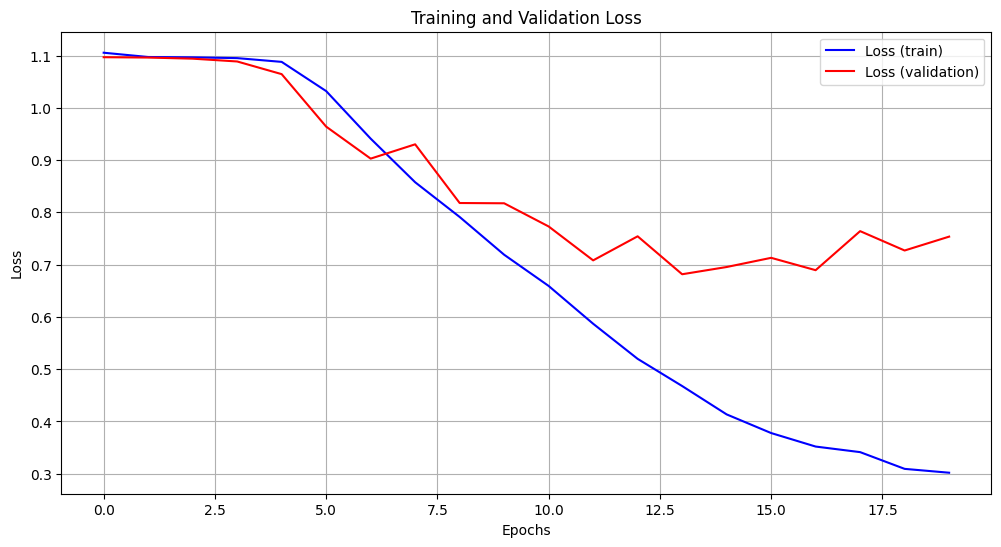

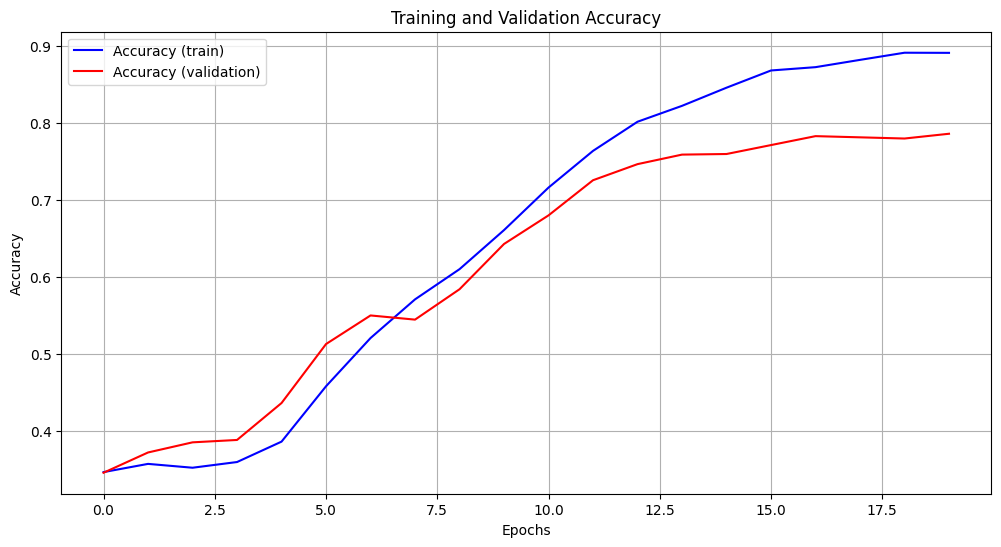

In [88]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Loss (train)', color='blue')
    plt.plot(history.history['val_loss'], label='Loss (validation)', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ đồ thị accuracy
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Accuracy (train)', color='blue')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation)', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Sau khi huấn luyện mô hình, vẽ các đồ thị
plot_loss(history)
plot_accuracy(history)

In [89]:
def preprocess_input(raw_input, tokenizer):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre =" ".join(input_text_pre)
    input_text_pre_accent= ViTokenizer.tokenize(input_text_pre)
    print("text preprocessed: ",input_text_pre_accent)
    tokenizer_data_text=tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen =512)
    return vec_data
def inference_model(input_feature,model):
    output=model(input_feature).numpy()[0]
    result =output.argmax()
    conf =float(output.max())
    label_dictionary={'negative':0,'neutral':1,'positive':2}
    label =list(label_dictionary.keys())
    return label[int(result)],conf
def prediction(raw_input, tokenizer,model):
    input_model=preprocess_input(raw_input,tokenizer_data)
    result,conf=inference_model(input_model,model)
    return result, conf
def input_and_predict(tokenizer, model):
    # Nhận đầu vào từ người dùng
    new_input = input("Nhập câu để dự đoán cảm xúc: ")

    # Xử lý câu đầu vào
    input_model = preprocess_input(new_input, tokenizer)

    # Dự đoán kết quả
    result, conf = inference_model(input_model, model)

    # In kết quả dự đoán và độ tin cậy
    print(f"Dự đoán cảm xúc: {result}")
    print(f"Độ tin cậy của dự đoán: {conf}")
m_model= generate_model()
m_model = load_model('model.keras')
with open(r"tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

# Gọi hàm input và dự đoán
input_and_predict(my_tokenizer, m_model)

Nhập câu để dự đoán cảm xúc: phim dở
text preprocessed:  phim dở
Dự đoán cảm xúc: negative
Độ tin cậy của dự đoán: 0.9999961853027344
